In [1]:
%load_ext autoreload
%autoreload 2

import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys
import os
import particle
# using getlogin() returning username
user_name = os.getlogin()

sys.path.append(f'/home/{user_name}/Documents/Atmos_Pandora/apc_atmo_repo/Anatree/')
from anatree_class import Anatree
from  ana_tools import *


plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True,
                     'figure.figsize': [14,6]
                     })

anatree:Anatree

In [2]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum_300k_new.root", entry_start=0, entry_stop=1000, load_data=False)
anatree.tree:uproot.TTree

In [3]:
anatree.read_parquet('../../../../../../data/atm_50k_hd_AV_2.5_random/parquet_new',batches=-1, concat=False)#, types=['nu','reco_tracks','reco_showers'])#, n_rows=100)
# merged = anatree.get_full_reco_tracks().collect()
# pl.collect_all(anatree.nu)

Reading nu files... 30/30
Reading geant files... 30/30
Reading reco_tracks files... 30/30
Reading reco_showers files... 30/30
Reading pfp files... 30/30


In [4]:
nu = anatree.nu
geant = anatree.geant
nu = anatree.nu
geant = anatree.geant
shw = anatree.reco_showers
tracks = anatree.reco_tracks
pfp = anatree.pfp
merged:pl.DataFrame
merged = 0
for i,n in enumerate(nu[:]):
    df = anatree.get_full_reco_tracks(tracks[i], geant[i], nu[i])
    df = df.collect()
    if i == 0:
        merged = df
    else:
        merged = pl.concat([merged,df])

In [5]:
nu = merge_same_df(nu)
tracks = merge_same_df(tracks)
shw = merge_same_df(shw)
pfp = merge_same_df(pfp)

In [6]:
shf:pl.DataFrame
tkf:pl.DataFrame
shf = shw.groupby(selection_events()).agg(
    ntrks = pl.col('pfp_parentID').count()
)
tkf = tracks.groupby(selection_events()).agg(
    nshws = pl.col('pfp_parentID').count()
)

diff_ev = tkf.join(shf, on=selection_events(), how='outer')

diff_ev = diff_ev.fill_null(0).filter(
    ( pl.col('ntrks') != pl.col('nshws') ) 
).with_columns(
    test = pl.col('nshws').cast(pl.Int16) - pl.col('ntrks') 
)

filter_diff = diff_ev.select(selection_events())

shw_diff = shw.join(filter_diff, on=selection_events(), how='inner')
shw_diff
    

subrun,event,shwr_bestplane_pandoraShower,shwr_length_pandoraShower,shwr_startdcosx_pandoraShower,shwr_startdcosy_pandoraShower,shwr_startdcosz_pandoraShower,shwr_startx_pandoraShower,shwr_starty_pandoraShower,shwr_startz_pandoraShower,shwr_totEng_pandoraShower_x,shwr_totEng_pandoraShower_y,shwr_totEng_pandoraShower_z,shwr_dedx_pandoraShower_x,shwr_dedx_pandoraShower_y,shwr_dedx_pandoraShower_z,shwr_mipEng_pandoraShower_x,shwr_mipEng_pandoraShower_y,shwr_mipEng_pandoraShower_z,shwr_hasPFParticle_pandoraShower,shwr_PFParticleID_pandoraShower,shwr_pidmvamu_pandoraShower,shwr_pidmvae_pandoraShower,shwr_pidmvapich_pandoraShower,shwr_pidmvaphoton_pandoraShower,shwr_pidmvapr_pandoraShower,showerID_pandoraShower,pfp_parentID,has_valid_pfp
i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,f32,f32,f32,f32,f32,i16,i16,i16
0,4,1,96.466362,0.232655,0.909402,0.344761,37.694302,-406.247253,137.840637,464.195648,443.998779,451.559448,5.887189,9.460866,10.982842,-99999.0,-99999.0,-99999.0,1,0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,0,-1,0
0,4,1,16.136236,-0.509681,0.848531,-0.1422,122.727028,-275.15802,204.328583,107.303009,126.432251,106.487022,2.626674,3.108196,2.307724,-99999.0,-99999.0,-99999.0,1,1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,-1,0
0,4,0,5.87562,0.249815,0.784212,-0.567983,114.148003,-259.015442,201.038361,64.419044,-999.0,61.740231,9.92446,-999.0,9.538828,-99999.0,-99999.0,-99999.0,1,2,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,-1,0
0,4,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,8.52058,24.656363,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,1
0,5,0,24.156116,-0.226436,-0.57362,0.787202,92.810913,-494.948029,347.923615,94.819046,91.221069,91.665482,2.29058,2.629945,2.168712,-99999.0,-99999.0,-99999.0,1,0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,0,-1,0
0,5,0,9.15351,-0.842969,-0.392632,0.367755,48.093544,-491.475372,350.72171,46.294029,45.734295,51.824993,4.087903,2.750652,1.782876,-99999.0,-99999.0,-99999.0,1,1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,-1,1
0,5,1,9.786713,0.196534,0.752078,0.629089,93.6007,-490.392273,349.062988,64.850342,61.339409,38.52132,2.676831,7.194021,2.474085,-99999.0,-99999.0,-99999.0,1,2,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,-1,0
0,5,0,5.850799,-0.972875,0.079743,-0.217152,91.186913,-494.322784,347.532867,51.982449,61.798157,54.32618,3.52661,4.127992,15.524368,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,0
0,5,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.743419,23.67831,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,4,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,4,-1,1


In [126]:
shw_valid = shw.filter(
    (pl.col('shwr_startx_pandoraShower') != -999) &
    (pl.col('shwr_starty_pandoraShower') != -999) &
    (pl.col('shwr_startz_pandoraShower') != -999)
    # (pl.col('shwr_totEng_pandoraShower_x') != -999) | (pl.col('shwr_totEng_pandoraShower_y') != -999) | (pl.col('shwr_totEng_pandoraShower_z') != -999)
# ).filter(
#     True
    # (pl.col('shwr_dedx_pandoraShower_x') != -999) & (pl.col('shwr_dedx_pandoraShower_y') != -999) & (pl.col('shwr_dedx_pandoraShower_z') != -999)
).filter(
    pl.col('shwr_length_pandoraShower') != -999
)
shf:pl.DataFrame
tkf:pl.DataFrame
shf = shw.groupby(selection_events()).agg(
    ntrks = pl.col('pfp_parentID').count()
)
tkf = tracks.groupby(selection_events()).agg(
    nshws = pl.col('pfp_parentID').count()
)

diff_ev = tkf.join(shf, on=selection_events(), how='outer')

diff_ev = diff_ev.fill_null(0).filter(
    ( pl.col('ntrks') != pl.col('nshws') ) 
).with_columns(
    test = pl.col('nshws').cast(pl.Int16) - pl.col('ntrks') 
)

filter_diff = diff_ev.select(selection_events())

pfp_diff = pfp.join(filter_diff, on=selection_events(), how='inner')
pfp_diff.groupby(selection_events(['pfp_isTrack'])).agg().sort(selection_events())


subrun,event,pfp_isTrack
i32,i32,i16
0,4,1
0,4,0
0,5,1
0,5,0
0,9,0
0,9,1
0,19,0
0,19,1
1,4,1


In [125]:
trk_id = tracks.select(selection_events(['trkPFParticleID_pandoraTrack']))
shw_id = shw_valid.select(selection_events(['shwr_PFParticleID_pandoraShower']))
diff_id = shw_id.join(trk_id, left_on=selection_events(['shwr_PFParticleID_pandoraShower']), right_on=selection_events(['trkPFParticleID_pandoraTrack']), how='anti')
diff_id.groupby(selection_events()).agg().sort(selection_events())

shw_diff = shw.join(diff_id, on=selection_events(['shwr_PFParticleID_pandoraShower']), how='inner')
shw_diff.groupby(selection_events()).agg().sort(selection_events())
print(f'Total extra showers left: {len(shw_diff)}')
print(f'Total actually showers left: {len(shw_diff.filter(pl.col("has_valid_pfp")==1))}')

Total extra showers left: 83621
Total actually showers left: 6304


In [30]:
cc_numu = merged.filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
    )
n_numu_cc = len(cc_numu.groupby(selection_events()).agg())
print(f'Total events numu CC (with reconstructed track): {n_numu_cc}')
cc_numu_reco_mu = cc_numu.groupby(selection_events()).agg(
    has_mu_track = (pl.col('pdg_geant').abs() == 13).any()
)
cc_numu_reco_mu = cc_numu.join(cc_numu_reco_mu, on=selection_events(),how='inner')

n_numu_cc_mu = len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==True).groupby(selection_events()).agg())
n_numu_cc_no_mu = len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==False).groupby(selection_events()).agg())
print(f'Total CC numu with reco mu: {n_numu_cc_mu}')
print(f'Total CC numu without reco mu: {n_numu_cc_no_mu}')
cc_numu_longest_track = cc_numu_reco_mu.sort(
    pl.col('trklen_pandoraTrack'), descending=True
    ).groupby(selection_events()).agg(
        longest = pl.col('trklen_pandoraTrack').first(),
        is_track = pl.col('has_valid_pfp').first(),
        pdg = pl.col('pdg_geant').first(),
        nu_en = pl.col('enu_truth').first(),
        has_mu_track = pl.col('has_mu_track').first()
        ).sort(
            selection_events()
        ).filter(
            (pl.col('pdg').abs()!=13)
        )
n_long_not_mu_with_mu = len(cc_numu_longest_track.filter(pl.col("has_mu_track")==True))
n_long_not_mu_without_mu = len(cc_numu_longest_track.filter(pl.col("has_mu_track")==False))
print(f'Total longest track NOT a muon (with reco muon): {n_long_not_mu_with_mu}')
print(f'Total longest track NOT a muon (without reco muon): {n_long_not_mu_without_mu}')
print(f'Failed longest track to be a muon (all cases) = {100*(n_long_not_mu_with_mu+n_long_not_mu_without_mu)/n_numu_cc:.2f}%')
print(f'Failed longest track to be a muon (when there is a reco muon) = {100*n_long_not_mu_with_mu/n_numu_cc_mu:.2f}%')

Total events numu CC (with reconstructed track): 74060
Total CC numu with reco mu: 69001
Total CC numu without reco mu: 5059
Total longest track NOT a muon (with reco muon): 10459
Total longest track NOT a muon (without reco muon): 5059
Failed longest track to be a muon (all cases) = 20.95%
Failed longest track to be a muon (when there is a reco muon) = 15.16%


In [24]:
cc_numu = merged.filter(
    (pl.col('ccnc_truth')==0) & (pl.col('nuPDG_truth').abs()==14)
    ).filter(
        pl.col('has_valid_pfp')==True
    )

print('Using PFP selection of tracks or showers')
# n_numu_cc = len(cc_numu.groupby(selection_events()).agg())
print(f'Total events numu CC (with reconstructed track): {n_numu_cc}')
cc_numu_reco_mu = cc_numu.groupby(selection_events()).agg(
    has_mu_track = (pl.col('pdg_geant').abs() == 13).any()
)
cc_numu_reco_mu = cc_numu.join(cc_numu_reco_mu, on=selection_events(),how='inner')


# n_numu_cc_mu = len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==True).groupby(selection_events()).agg())
# n_numu_cc_no_mu = len(cc_numu_reco_mu.filter(pl.col("has_mu_track")==False).groupby(selection_events()).agg())
print(f'Total CC numu with reco mu: {n_numu_cc_mu}')
print(f'Total CC numu without reco mu: {n_numu_cc_no_mu}')
cc_numu_longest_track = cc_numu_reco_mu.sort(
    pl.col('trklen_pandoraTrack'), descending=True
    ).groupby(selection_events()).agg(
        longest = pl.col('trklen_pandoraTrack').first(),
        is_track = pl.col('has_valid_pfp').first(),
        pdg = pl.col('pdg_geant').first(),
        nu_en = pl.col('enu_truth').first(),
        has_mu_track = pl.col('has_mu_track').first()
        ).sort(
            selection_events()
        ).filter(
            (pl.col('pdg').abs()!=13)
        )
n_long_not_mu_with_mu = len(cc_numu_longest_track.filter(pl.col("has_mu_track")==True))
n_long_not_mu_without_mu = len(cc_numu_longest_track.filter(pl.col("has_mu_track")==False))
print(f'Total longest track NOT a muon (with reco muon): {n_long_not_mu_with_mu}')
print(f'Total longest track NOT a muon (without reco muon): {n_long_not_mu_without_mu}')
print(f'Failed longest track to be a muon (all cases) = {100*(n_long_not_mu_with_mu+n_long_not_mu_without_mu)/n_numu_cc:.2f}%')
print(f'Failed longest track to be a muon (when there is a reco muon) = {100*n_long_not_mu_with_mu/n_numu_cc_mu:.2f}%')


Using PFP selection of tracks or showers
Total events numu CC (with reconstructed track): 74060
Total CC numu with reco mu: 69001
Total CC numu without reco mu: 5059
Total longest track NOT a muon (with reco muon): 5674
Total longest track NOT a muon (without reco muon): 6247
Failed longest track to be a muon (all cases) = 16.10%
Failed longest track to be a muon (when there is a reco muon) = 8.22%


### Conclusion
By using pandora selection of reconstruction to be shower or track:

- There are 953 $\nu_\mu (CC)$ events in which there is no track reconstructed (only showers). 

- There is an increse of 1188 of muons not being reconstructed as tracks

- However, there is a reduction of 4785 of failed assumption of longest track with as muon

Before applying Pandora selection: 

In [11]:
geant = geant[0].collect()

In [12]:
geant:pl.DataFrame

mother_pi_0 = geant.filter(
    (pl.col('Mother_geant')==0) & (pl.col('pdg_geant')==111) 
).select(
    selection_events(['TrackId_geant'])
)
pi_0_daugthers = geant.join(
    mother_pi_0,
    left_on=selection_events(['Mother_geant']),
    right_on=selection_events(['TrackId_geant']),
    how='inner'
).select(
    selection_events(['TrackId_geant'])
)

tracks_of_pi_0 = tracks.join(pi_0_daugthers, left_on=selection_events(['trkg4id_pandoraTrack']), right_on=selection_events(['TrackId_geant']))
tracks_of_pi_0

subrun,event,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,ntrkhits_pandoraTrack_x,ntrkhits_pandoraTrack_y,ntrkhits_pandoraTrack_z,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,…,trkstartdcosy_pandoraTrack,trkstartdcosz_pandoraTrack,trkenddcosx_pandoraTrack,trkenddcosy_pandoraTrack,trkenddcosz_pandoraTrack,trkthetaxz_pandoraTrack,trkthetayz_pandoraTrack,trkmom_pandoraTrack,trkmomrange_pandoraTrack,trklen_pandoraTrack,trksvtxid_pandoraTrack,trkpidndf_pandoraTrack_x,trkpidndf_pandoraTrack_y,trkpidndf_pandoraTrack_z,trkpidchi_pandoraTrack_x,trkpidchi_pandoraTrack_y,trkpidchi_pandoraTrack_z,trkpidchipr_pandoraTrack_x,trkpidchipr_pandoraTrack_y,trkpidchipr_pandoraTrack_z,trkpidchika_pandoraTrack_x,trkpidchika_pandoraTrack_y,trkpidchika_pandoraTrack_z,trkpidchipi_pandoraTrack_x,trkpidchipi_pandoraTrack_y,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack,pfp_parentID,has_valid_pfp
i32,i32,i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i16,i16
0,1,0,129.836563,110.626808,491.586517,39.346676,39.117794,38.125942,320,320,320,1,1,1,22,22,22,0.864905,0.856849,0.738818,1.0,1.0,1.0,1.390899,12.187672,2.068537,72,67,22,289.045502,438.344147,527.806458,74.330551,321.574554,417.696625,530.928711,…,-0.632279,0.205379,0.939527,-0.251529,0.232425,1.302496,-1.256725,1.0,0.200049,39.431458,-1,43,39,17,-99999.0,-99999.0,-99999.0,315.809326,414.130859,388.268494,169.526199,162.707581,223.695099,48.689831,48.189114,75.537567,30.742678,31.406918,44.366299,1.759832,2.181928,0.868701,0,1,0,-1,0
0,5,1,48.635715,57.215668,26.978184,9.83387,9.586802,6.573584,70,70,70,1,1,1,22,22,22,0.782773,0.728834,0.780188,1.0,1.0,1.0,0.862211,6.805511,1.289282,18,20,19,47.425701,-489.740448,350.861786,118.088303,39.083832,-493.661407,354.487122,…,-0.391421,0.358767,-0.833447,-0.406279,0.374571,-1.170302,-0.828898,1.0,0.110782,9.920293,-1,16,18,17,-99999.0,-99999.0,-99999.0,193.808487,351.844269,292.222504,113.124786,200.011688,158.747787,45.294376,53.260178,42.428505,33.164371,38.116367,27.825895,2.305274,0.619294,1.549049,1,1,1,-1,0
0,5,2,40.67395,43.685688,40.357395,11.381208,10.333901,9.796354,69,69,69,1,1,1,22,22,22,0.515584,0.485178,0.280327,0.982942,1.0,0.948741,2.793275,0.485891,0.746108,12,22,14,93.6007,-490.392273,349.062988,117.436478,95.885925,-482.190887,356.613434,…,0.718558,0.664513,0.200195,0.686369,0.699156,0.299474,0.824455,1.0,0.116932,11.424881,-1,10,20,12,-99999.0,-99999.0,-99999.0,319.809784,124.838394,199.93895,180.720169,75.678268,106.006744,46.397686,33.867653,29.509956,32.799812,27.487671,19.940058,1.015683,4.609737,2.703409,1,1,2,-1,1
0,8,0,130627.234375,12722.293945,9.1137e10,270.05722,234.564041,241.559723,490,490,490,1,1,1,22,22,22,0.778534,0.64185,0.760806,0.490266,0.511372,0.452048,0.752231,0.501659,0.50162,2425,1271,999,-302.102295,515.511536,1349.214722,44.249027,-359.527954,333.838623,1263.011353,…,-0.755189,0.63

In [13]:
wrong_track = len(merged.filter(
    (pl.col('pdg_geant').abs() == 11) | (pl.col('pdg_geant')==22) 
).filter(
    pl.col('has_valid_pfp')==1
)
)
all = len(merged.filter(pl.col('has_valid_pfp')==1))
wrong_track/all

0.16584441022740365

In [139]:
wrong_shower = len(merged.filter(
    (pl.col('pdg_geant').abs() != 11) & (pl.col('pdg_geant')!=22) 
).filter(
    pl.col('has_valid_pfp')==0
)
)
all = len(merged.filter(pl.col('has_valid_pfp')==0))
wrong_shower/all

0.17172787485957494

In [15]:
test = nu.with_columns(
    theta = pl.col('nu_dcosy_truth')
).filter(
    pl.col('enu_truth')<0.5
)



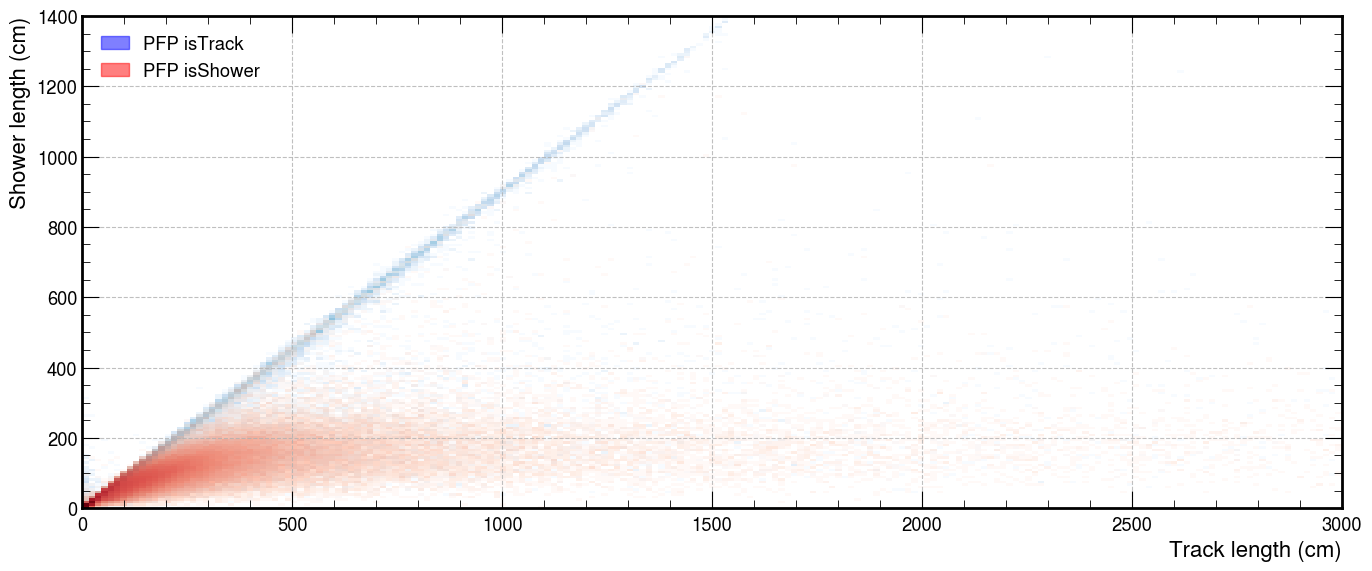

In [103]:
import matplotlib.pylab as plab
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# modify existing Reds colormap with a linearly fading alpha
red = plab.cm.Reds  # original colormap
fading_red = red(np.arange(red.N)) # extract colors
fading_red[:, -1] = np.linspace(0.5, 1, red.N) # modify alpha
fading_red = ListedColormap(fading_red) # convert to colormap

test = merged.select(selection_events(['trklen_pandoraTrack','trkPFParticleID_pandoraTrack','has_valid_pfp','pdg_geant']))
# test = test.with_columns(
#     has_valid_pfp = pl.when((pl.col('pdg_geant').abs() == 11) | pl.col('pdg_geant'))
# )

test = test.join(shw.select(selection_events(['shwr_length_pandoraShower','shwr_PFParticleID_pandoraShower'])),
                 left_on=selection_events(['trkPFParticleID_pandoraTrack']),
                 right_on=selection_events(['shwr_PFParticleID_pandoraShower']))
binsx=np.linspace(0,3000,200)
binsy=np.linspace(0,1400,200)
test1 = test.filter(pl.col('has_valid_pfp')==1)
test2 = test.filter(pl.col('has_valid_pfp')==0)
plt.hist2d(test1['trklen_pandoraTrack'], test1['shwr_length_pandoraShower'], bins=[binsx,binsy], norm=LogNorm(), cmap="Blues");
plt.hist2d(test2['trklen_pandoraTrack'], test2['shwr_length_pandoraShower'], bins=[binsx,binsy], norm=LogNorm(), cmap=fading_red);

plt.xlabel('Track length (cm)')
plt.ylabel('Shower length (cm)')
import matplotlib.patches as mpatches

blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='PFP isTrack')
red_patch = mpatches.Patch(color='red', alpha=0.5, label='PFP isShower')
plt.legend(handles=[blue_patch,red_patch], loc='upper left')

In [138]:
# shw.sort('shwr_length_pandoraShower'groupby(selection_events()).agg(
    
shw_invalid = shw.filter(
    (pl.col('shwr_startx_pandoraShower') == -999) |
    (pl.col('shwr_starty_pandoraShower') == -999) |
    (pl.col('shwr_startz_pandoraShower') == -999)
    # (pl.col('shwr_totEng_pandoraShower_x') != -999) | (pl.col('shwr_totEng_pandoraShower_y') != -999) | (pl.col('shwr_totEng_pandoraShower_z') != -999)
# ).filter(
#     True
    # (pl.col('shwr_dedx_pandoraShower_x') != -999) & (pl.col('shwr_dedx_pandoraShower_y') != -999) & (pl.col('shwr_dedx_pandoraShower_z') != -999)
).filter(
    pl.col('shwr_length_pandoraShower') == -999
)
shw_invalid.filter(pl.col('has_valid_pfp')==1)

subrun,event,shwr_bestplane_pandoraShower,shwr_length_pandoraShower,shwr_startdcosx_pandoraShower,shwr_startdcosy_pandoraShower,shwr_startdcosz_pandoraShower,shwr_startx_pandoraShower,shwr_starty_pandoraShower,shwr_startz_pandoraShower,shwr_totEng_pandoraShower_x,shwr_totEng_pandoraShower_y,shwr_totEng_pandoraShower_z,shwr_dedx_pandoraShower_x,shwr_dedx_pandoraShower_y,shwr_dedx_pandoraShower_z,shwr_mipEng_pandoraShower_x,shwr_mipEng_pandoraShower_y,shwr_mipEng_pandoraShower_z,shwr_hasPFParticle_pandoraShower,shwr_PFParticleID_pandoraShower,shwr_pidmvamu_pandoraShower,shwr_pidmvae_pandoraShower,shwr_pidmvapich_pandoraShower,shwr_pidmvaphoton_pandoraShower,shwr_pidmvapr_pandoraShower,showerID_pandoraShower,pfp_parentID,has_valid_pfp
i32,i32,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,f32,f32,f32,f32,f32,i16,i16,i16
0,4,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,8.52058,24.656363,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,1
0,5,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.743419,23.67831,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,4,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,4,-1,1
10000,9,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,50.862827,-999.0,11.364527,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,3,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,3,-1,1
10002,10,2,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,13.66145,-999.0,20.630627,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,5,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,5,-1,1
10005,12,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,15.831324,16.170006,15.645539,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,-1,1
10005,14,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,23.803122,-999.0,15.391177,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,4,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,4,-1,1
10011,9,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,60.616268,4.183393,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,7,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,7,-1,1
10017,16,1,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.273,13.883651,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,2,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,-1,1
10018,8,0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,5.851056,7.950606,-999.0,-999.0,-999.0,-999.0,-99999.0,-99999.0,-99999.0,1,11,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,11,-1,1
